# Basic deep learning models for the MNIST handwritten digit dataset

A collection of machine learning notebooks that demonstrate supervised learning on a classification task. Since it's the 'Hello World' or deep learning, let's work with the MNIST handwritten digits.

## Softmax Classifier
The handwritten digit classification task requires the model to classify an 8x8 pixel image input into one of ten possible classes. Let's be modern and use a softmax classifier as the output layer of our model. The Softmax classifier is effectively a generalization of logistic regression from two to *C* classes, and outputs a vector of *C* activations which can be interpreted as probabilities. For example, the vector [0.6, 0.2, 0.1, 0.05, 0.05] expresses a 60% confidence that what the model's looking at is class 0, 20% confidence in class 1, etc. 

## First, an even simpler dataset...

To prototype the model in TensorFlow, however, (and also so that we can visualise what the model is learning in a more manageable number of dimensions) let's get to grips with an easier dataset. We'll use a built-in function of scikit-learn to create a synthetic 'blobs' dataset, with only two input features, and ten output classes. While this has the same number of output classes (10) as the handwritten digit-recognition problem, the output class can be predicted from only two input features, as opposed to 64. The handwritten digit model will therefore have more units, but from the perspective of the output layer, and the slightly grindy process of plumbing the data in to the model, it shouldn't be too much more complicated.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets

import math
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline

/home/nickdbn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
n_samples = 2000
n_classes = 10
n_features = 2

blobs = sklearn.datasets.make_blobs(n_samples=n_samples, random_state=5, n_features=n_features, centers=n_classes)

X, Y = blobs
X, Y = X.T, Y.reshape(1, Y.shape[0])

# Sanity check the shape of our data sets and what they look like
print ("Shape X:", X.shape)
print ("X[:,0]", X[:,0])
print ("Shape Y:", Y.shape)
print ("Y[:,0]", Y[:,0])

Shape X: (2, 2000)
X[:,0] [4.08682492 1.53264472]
Shape Y: (1, 2000)
Y[:,0] [9]


Next, let's take a look at the number of data examples in each class:

In [3]:
np.unique (Y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200]))

So in this case, sklearn.datasets.make_blobs generates equal numbers of each class, which is sometimes important for the training set. However, we can't always rely on this being the case, so we'll make sure our function which splits the data into train, dev and test sets is robust to this and always produces the same number of training examples in each class in the train set.

To establish some terminology, our blobs dataset comes in the form of X,Y pairs. X is a two dimensional matrix that has *n* rows, where *n* is the number of features (in this case, two) and *m* columns, where *m* is the number of training examples. Each *X* is used to make a prediction *Y_hat* of the corresponding *Y*, which is the correct label.

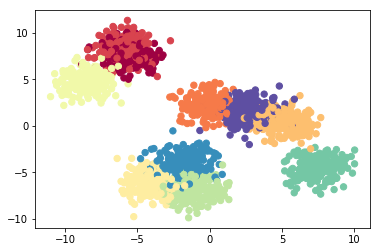

In [4]:
# Scatter plot of the data:
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

Great! We've created a two-dimensional data set with ten possible output classes. The job of our network will be to learn how to separate a given item into one of these classes based on its input features (in this case, it's X1 and X2 co-ordinates which are mapped to X and Y on the graph above. Just like for handwriting digit recognition problem, some of these classes are easily separable (think the handwritten digits 0 and 1) and some have a degree of overlap (handwritten 4 and 9 are notoriously hard to separate.) So this two-dimensional version of the data can be thought of as a cartoon for the more challenging task.

# Train, Dev and Test sets
First, we need to do some data-munging to split the data up into training and validation sets. To establish some good practice we're going to use three sets, train, dev and test. The dev set is used in place of the test set to evaluate and iterate the performance of the network, and tune hyperparameters. As repeated iterating on can lead to some overfitting of the test set, it's really bad practice to use the final test set for this.

In [5]:
def get_train_dev_test_sets (X, Y, train_set_proportion = 0.9, dev_set_proportion = 0.05):
    """
    Takes set of features (X) as (n,m) matrix and labels (Y) as (1,m) matrix and splits them into train, test and 
    dev sets according to specified proportions. 
    Train set will have same number of examples of each class
    
    returns: train_set_X, train_set_Y, dev_set_X, dev_set_Y, test_set_X, test_set_Y
    """
    
    size_classes = np.unique(Y, return_counts = True)[1] # get an array of all class sizes

    # our training set contains train_set_proportion * smallest class size of each class
    size_smallest_class = min (np.unique (Y, return_counts = True)[1]) 
    size_train_set_class = int (train_set_proportion * size_smallest_class)
    size_dev_set_class = int (dev_set_proportion * size_smallest_class)
    
    
    num_classes = np.shape(np.unique(Y))[0]

    size_classes_cum = np.empty ((0)) 
    for i in range (0, num_classes): # get an array of cumulative indices, starting with 0, for where each class starts
        size_classes_cum = np.append (size_classes_cum, int (sum(size_classes[0:i])))
    # add on final size of the data set +1 so we can iterate i+1 over num_classes to get end indices
    size_classes_cum = np.append (size_classes_cum, int(Y.shape[1]))
    
    sorted_indices = np.argsort (Y[0,:]) # get the list of indices that will sort Y by class
    X_sorted = X[:, sorted_indices]
    Y_sorted = Y[:, sorted_indices] 
    

    
    # initialise sets
    train_set_X = np.empty ((X.shape[0], 0))
    train_set_Y = np.empty ((1, 0))
    dev_set_X = np.empty ((X.shape[0], 0))
    dev_set_Y = np.empty ((1, 0))
    test_set_X = np.empty ((X.shape[0], 0))
    test_set_Y = np.empty ((1, 0))
        
    for i in range (0, num_classes):
        X_this_class = X_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)]
        train_set_X = np.append (train_set_X, X_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)], axis=1)
        train_set_Y = np.append (train_set_Y, Y_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)], axis=1)

        dev_set_X = np.append (dev_set_X, X_sorted[:, int (size_classes_cum[i]+size_train_set_class):int (size_classes_cum[i]+size_train_set_class)+size_dev_set_class], axis=1)
        dev_set_Y = np.append (dev_set_Y, Y_sorted[:, int (size_classes_cum[i]+size_train_set_class):int (size_classes_cum[i]+size_train_set_class)+size_dev_set_class], axis=1)
        
        test_set_X = np.append (test_set_X, X_sorted[:, int (size_classes_cum[i]+size_train_set_class+size_dev_set_class):int(size_classes_cum[i+1])], axis=1)
        test_set_Y = np.append (test_set_Y, Y_sorted[:, int (size_classes_cum[i]+size_train_set_class+size_dev_set_class):int(size_classes_cum[i+1])], axis=1)

       
    # Finally, apply the same shuffle to X and Y sets
    train_shuffled_indices = np.arange (train_set_X.shape[1])
    dev_shuffled_indices = np.arange (dev_set_X.shape[1])
    test_shuffled_indices = np.arange (test_set_X.shape[1])

    np.random.shuffle (train_shuffled_indices)
    np.random.shuffle (dev_shuffled_indices)
    np.random.shuffle (test_shuffled_indices)

    train_set_X = train_set_X[:,train_shuffled_indices]
    train_set_Y = train_set_Y[:,train_shuffled_indices].astype (np.int16)    
    dev_set_X = dev_set_X[:,dev_shuffled_indices]
    dev_set_Y = dev_set_Y[:,dev_shuffled_indices].astype (np.int16)    
    test_set_X = test_set_X[:,test_shuffled_indices]
    test_set_Y = test_set_Y[:,test_shuffled_indices].astype (np.int16)    
    
    return train_set_X, train_set_Y, dev_set_X, dev_set_Y, test_set_X, test_set_Y

In [6]:
train_set_X, train_set_Y, dev_set_X, dev_set_Y, test_set_X, test_set_Y = get_train_dev_test_sets (X, Y)

print ("train_set_X.shape: ", train_set_X.shape)
print ("train_set_Y.shape: ", train_set_Y.shape)
print ("dev_set_X.shape:", dev_set_X.shape)
print ("dev_set_Y.shape:", dev_set_Y.shape)
print ("test_set_X.shape:", test_set_X.shape)
print ("test_set_Y.shape:", test_set_Y.shape)

print ("And let's just sanity check the test Y data:")
print (test_set_Y)

train_set_X.shape:  (2, 1800)
train_set_Y.shape:  (1, 1800)
dev_set_X.shape: (2, 100)
dev_set_Y.shape: (1, 100)
test_set_X.shape: (2, 100)
test_set_Y.shape: (1, 100)
And let's just sanity check the test Y data:
[[6 4 5 7 9 6 5 7 2 0 4 2 8 6 6 0 3 3 9 2 6 8 8 1 3 3 3 6 4 6 7 4 1 9 9 3 8
  6 9 7 5 0 4 5 7 3 4 7 1 9 9 4 0 3 0 5 1 4 2 0 7 2 1 3 2 1 8 1 5 2 8 3 1 2
  9 2 4 0 1 8 5 1 5 7 9 8 0 7 0 4 5 5 6 9 6 0 2 7 8 8]]


Phew. Just to recap, we've now split the data (X, Y) into train, dev, and test sets. We'll use these sets to initially train the model, tune hyperparameters, and finally evaluate the model, respectively. This was a lot of code, but we can re-use it later.


# Creating a supervised learning model in TensorFlow

Let's start by creating a few utility functions. 

In [7]:
def convert_to_one_hot(Y, C): 
    """
    Converts a vector Y of multiclass-responses coded as integer values (0, 1, 2, etc.... C-1) 
    to a (C,m) dimensional matrix where each row represents a response, and values are either 0 or 1
    """
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [8]:
print (train_set_Y[:,0:10])

train_set_Y_one_hot = convert_to_one_hot (train_set_Y,  10)
dev_set_Y_one_hot = convert_to_one_hot (dev_set_Y,  10)
test_set_Y_one_hot = convert_to_one_hot (test_set_Y,  10)
print ("...converts to:")
print (train_set_Y_one_hot[:, 0:10])

[[9 4 2 9 0 9 0 8 0 6]]
...converts to:
[[ 0.  0.  0.  0.  1.  0.  1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  1.  0.  1.  0.  0.  0.  0.]]


In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [10]:
def create_placeholders(n_x, n_y):
    """
    Creates placeholders for input feature vector (X) and labels vector (Y) 
    
    Arguments:
    n_x -- scalar, size of the input feature vector 
    n_y -- scalar, number of classes 
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    """

    X = tf.placeholder(dtype="float", shape=(n_x, None), name="X")
    Y = tf.placeholder(dtype="float", shape=(n_y, None), name="Y")
    
    return X, Y

In [11]:
X, Y = create_placeholders(2, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(2, ?), dtype=float32)
Y = Tensor("Y:0", shape=(10, ?), dtype=float32)


In [12]:
def initialize_parameters_3layers(size_input, size_l1, size_l2, size_l3):
    """
    Initializes parameters for a 3 layer tensorflow neural network, where l1 is the first hidden layer 
    and l3 is the output layer.
    Uses Xavier initialization.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable ("W1", [size_l1,size_input], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable ("b1", [size_l1,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable ("W2", [size_l2,size_l1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable ("b2", [size_l2,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable ("W3", [size_l3,size_l2], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable ("b3", [size_l3,1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [13]:
def forward_propagation_3layers(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [14]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [15]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    X, Y = create_placeholders (n_x, n_y)
    parameters = initialize_parameters_3layers(size_input = 2, size_l1 = 25, size_l2 = 10, size_l3 = 10)
    Z3 = forward_propagation_3layers (X, parameters)
    cost = compute_cost (Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                # the line that runs the optimizer
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

## Running the model
Now let's train the model!

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 2.521253
Cost after epoch 100: 0.729585
Cost after epoch 200: 0.376803
Cost after epoch 300: 0.323949
Cost after epoch 400: 0.304391
Cost after epoch 500: 0.297478
Cost after epoch 600: 0.290949
Cost after epoch 700: 0.292472
Cost after epoch 800: 0.287848
Cost after epoch 900: 0.291119
Cost after epoch 1000: 0.279909
Cost after epoch 1100: 0.286927
Cost after epoch 1200: 0.280877
Cost after epoch 1300: 0.283299
Cost after epoch 1400: 0.283584


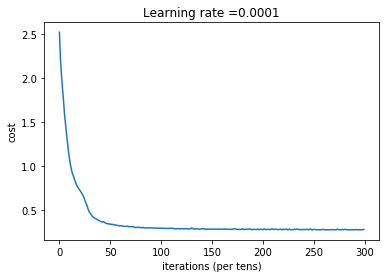

Parameters have been trained!
Train Accuracy: 0.877222
Test Accuracy: 0.84


In [16]:
parameters = model(train_set_X, train_set_Y_one_hot, dev_set_X, dev_set_Y_one_hot)

Straight out of the box, the model's achieves 87.6% accuracy on the train set and 84% on the test set. That's not terrible, and there's a number of tricks that we might use to improve the learning algorithm.

Let's dig a bit deeper into how the model's represented the feature space by plotting the decision boundary, superimposed over the training set.

To do that, we need to define a couple of functions using tensorflow to get the model to make a set of predictions:

In [17]:
def predict(X, parameters):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (softmax: probability/confidence of each class)
    """

    # Retrieve the parameters from the dictionary "parameters"     
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    x = tf.placeholder("float", [2, None])  # IMPORTANT Note we need to use None here as we don't know how many training
                                            # examples will be passed in via feed_dict

                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
  
    p = tf.argmax(Z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

Getting the model to make a single prediction:

In [18]:
predict_idx = 0

predict_set_X = test_set_X[:,predict_idx]
predict_set_X = predict_set_X.reshape(2,1) 
predict_set_X.shape

prediction = predict (predict_set_X.astype(np.float32), parameters)
print ("The model predicted:", prediction)

print ("The correct label is:", test_set_Y[:, predict_idx])

The model predicted: [6]
The correct label is: [6]


Now let's predict a vector of values rather than just one. Note that the key thing to get this to work was to specify in the `predict` function that `x=tf.placeholder("float", [2, None])` with the `None` being critical, as we don't know at the stage of specifying the placeholder how big the X matrix that's going to be passed in via feed_dict is.

In [19]:
predict_idx_low = 0
predict_idx_high = 10

predict_set_X = test_set_X.astype(np.float32)[:,predict_idx_low:predict_idx_high]
# print ("predict_set_X:\n", predict_set_X)
#predict_set_X = predict_set_X.reshape(2,1) 
# predict_set_X.shape
# type (predict_set_X[0,0]) # confirm type is float32

prediction = predict (predict_set_X, parameters)
print ("The model predicted:", prediction)

print ("The correct labels are:\n", test_set_Y[:, predict_idx_low:predict_idx_high])

The model predicted: [6 4 5 7 9 6 5 7 9 0]
The correct labels are:
 [[6 4 5 7 9 6 5 7 2 0]]


More generally, the model has learned to make classifications based on the following segmentation of feature space:

In [20]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xx = xx.astype(np.float32)
    yy = yy.astype(np.float32)
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contour(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.colorbar()

In [21]:
print (train_set_Y.shape)

(1, 1800)


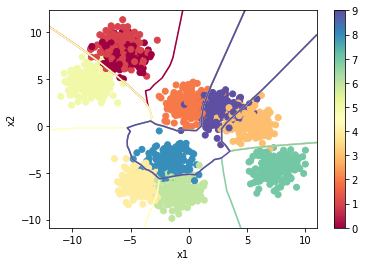

In [22]:
plot_decision_boundary (lambda x: predict (x.T, parameters), train_set_X, train_set_Y[0,:]) 
                                                # remember to use the original train_set_Y not the ..._one_hot version

From visualising the training boundaries, we can see that the model's doing a decent job at separating the two-dimensional feature space for all classes apart from 0 and 1, which have a high degree of overlap. It seems that the model's decided to classify all these examples as 0. We can confirm this by going in and looking at the accuracy of the model's predictions broken down by class:

In [23]:
def evaluate_predictions_byclass (X, Y, num_classes = 10):

    predict_set_X = X.astype(np.float32)
    # print ("predict_set_X:\n", predict_set_X)
    #predict_set_X = predict_set_X.reshape(2,1) 
    # predict_set_X.shape
    # type (predict_set_X[0,0]) # confirm type is float32

    prediction = predict (predict_set_X, parameters)
    print ("The model predicted:", prediction)
    print ("The correct labels are:\n", test_set_Y)
    
    evaluate_predictions = np.append(prediction.reshape(test_set_Y.shape), test_set_Y, axis=0)

    correct = (evaluate_predictions[0,:] == evaluate_predictions[1,:]) # get a vector of True/False values

    classes = np.arange(0, num_classes)

    correct_by_class = np.bincount(evaluate_predictions[0,:], weights=correct) # weight the bincount by True/False (ie only count correct responses)
    totals_by_class = np.bincount(evaluate_predictions[1,:])

    accuracy_by_class = np.divide (correct_by_class, totals_by_class)
    return accuracy_by_class

In [24]:
evaluate_predictions_byclass (test_set_X, test_set_Y)

The model predicted: [6 4 5 7 9 6 5 7 9 0 4 2 8 8 6 0 3 3 9 2 6 8 4 1 9 3 3 6 4 6 7 4 1 9 9 3 4
 6 9 7 0 0 4 5 7 3 4 7 1 9 2 4 1 3 1 5 1 6 2 0 7 2 1 3 2 1 8 1 5 2 8 3 1 2
 3 2 8 1 1 8 5 1 5 7 9 8 1 7 1 6 5 5 6 9 6 0 2 7 8 8]
The correct labels are:
 [[6 4 5 7 9 6 5 7 2 0 4 2 8 6 6 0 3 3 9 2 6 8 8 1 3 3 3 6 4 6 7 4 1 9 9 3 8
  6 9 7 5 0 4 5 7 3 4 7 1 9 9 4 0 3 0 5 1 4 2 0 7 2 1 3 2 1 8 1 5 2 8 3 1 2
  9 2 4 0 1 8 5 1 5 7 9 8 0 7 0 4 5 5 6 9 6 0 2 7 8 8]]


array([ 0.5,  1. ,  0.9,  0.9,  0.7,  0.9,  0.9,  1. ,  0.8,  0.8])

As expected, the 0 class suffers much worse performance than other classes.